# Introduction

You probably have experienced this before: You are in an underground carpark and you have just activated your navigation system. But the navigation system has trouble locating you on the map due to poor GPS signal quality caused by the concrete walls. Although, in this use case a better accuracy would only be a "nice to have", in other cases it could become a necessity for indoor applications.

To **improve the accuracy of indoor positioning systems**, we are asked to predict the indoor position of smartphones based on real-time sensor data in this competition.

The aim of this notebook is to give you an **introduction to the topic** and making you **familiar with the data**.

# Dataset Overview

The dataset we are working with is provided by the Chinese company XYZ10 specialized in indoor positioning technology. The dataset consists of path trace recordings of a person walking from one point to another. During the walk, the following sensor signals are recorded:
* accelerometer
* magnetic field
* gyroscope
* rotation vector
* WiFi
* Bluetooth iBeacon
* ground truths (waypoint locations)

Additional information on the data can be found on the [competition's Github page](https://github.com/location-competition/indoor-location-competition-20). There, you will also find some [webinar slides](https://github.com/location-competition/indoor-location-competition-20/blob/master/webinar.pdf).

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from dataclasses import dataclass

import matplotlib.pyplot as plt # visualization
plt.rcParams.update({'font.size': 14})
import seaborn as sns # visualization

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

from tqdm import tqdm

import json
import plotly.graph_objs as go
from PIL import Image

Let's have a first look at one of the trace files to get a rough feeling for the data. Unfortunately, this time we don't have the comfort of .csv format. Instead, we are provided text files. The **text files** start with a header and end with a footer containing some meta information. The **header and footer are lines which start with a has sign ('#')**. In between, we have the sensor data. The sensor data is **delimited with a tab** ('\t'). Each row starts with a **timestamp, followed by the sensor name and the sensor values**. However, if you try to read it with pandas and a specified delimiter, you will notice that the **number of columns in each row can vary depending on the sensor**. 

In [2]:
!head -n 15 "../input/indoor-location-navigation/train/5a0546857ecc773753327266/F2/5dccf516c04f060006e6e3c9.txt"

#	startTime:1573713056850
#	SiteID:5a0546857ecc773753327266	SiteName:西溪银泰城	FloorId:5a24ae78fe4e220014739c5e	FloorName:二层
#	Brand:OPPO	Model:PBCM10	AndroidName:8.1.0	APILevel:27	
#	type:1	name:BMI160 Accelerometer	version:2062600	vendor:BOSCH	resolution:0.0023956299	power:0.18	maximumRange:39.22661
#	type:4	name:BMI160 Gyroscope	version:2062600	vendor:BOSCH	resolution:0.0010681152	power:0.9	maximumRange:34.906586
#	type:2	name:AK09911 Magnetometer	version:1	vendor:AKM	resolution:0.5996704	power:2.4	maximumRange:4911.9995
#	type:35	name:BMI160 Accelerometer Uncalibrated	version:2062600	vendor:BOSCH	resolution:0.0023956299	power:0.18	maximumRange:39.22661
#	type:16	name:BMI160 Gyroscope Uncalibrated	version:2062600	vendor:BOSCH	resolution:0.0010681152	power:0.9	maximumRange:34.906586
#	type:14	name:AK09911 Magnetometer Uncalibrated	version:1	vendor:AKM	resolution:0.5996704	power:2.4	maximumRange:4911.9995
#	VersionName:v20191105-nightly-12-g9014429	VersionCode:399	
1573713056859	TYPE_WAYP

To retrieve the data, we will go through the file line by line and append the relevant data to its assigned array. Below, we can see that each array has a different shape. For example, we only has 6 data points for waypoint, while we have 1743 datapoints from the acceleration sensor.

The following code is copied and edited from [@ihelon's notebook](https://www.kaggle.com/ihelon/indoor-location-exploratory-data-analysis) and is originally from the [competition's Github page](https://github.com/location-competition/indoor-location-competition-20/blob/master/io_f.py).

In [4]:
# copy from https://github.com/location-competition/indoor-location-competition-20/blob/master/io_f.py

@dataclass
class ReadData:
    acce: np.ndarray
    acce_uncali: np.ndarray
    gyro: np.ndarray
    gyro_uncali: np.ndarray
    magn: np.ndarray
    magn_uncali: np.ndarray
    ahrs: np.ndarray
    wifi: np.ndarray
    ibeacon: np.ndarray
    waypoint: np.ndarray


def read_data_file(data_filename):
    acce = []
    acce_uncali = []
    gyro = []
    gyro_uncali = []
    magn = []
    magn_uncali = []
    ahrs = []
    wifi = []
    ibeacon = []
    waypoint = []

    with open(data_filename, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    for line_data in lines:
        line_data = line_data.strip()
        if not line_data or line_data[0] == '#':
            continue

        line_data = line_data.split('\t')

        if line_data[1] == 'TYPE_WAYPOINT':
            waypoint.append([int(line_data[0]), float(line_data[2]), float(line_data[3])])
            continue
       
        if line_data[1] == 'TYPE_ACCELEROMETER':
            acce.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue
        
        if line_data[1] == 'TYPE_ACCELEROMETER_UNCALIBRATED':
            acce_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue
        
        if line_data[1] == 'TYPE_GYROSCOPE':
            gyro.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_GYROSCOPE_UNCALIBRATED':
            gyro_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue
        
        if line_data[1] == 'TYPE_MAGNETIC_FIELD':
            magn.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_MAGNETIC_FIELD_UNCALIBRATED':
            magn_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_ROTATION_VECTOR':
            ahrs.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_WIFI':
            sys_ts = line_data[0]
            ssid = line_data[2]
            bssid = line_data[3]
            rssi = line_data[4]
            lastseen_ts = line_data[6]
            wifi_data = [sys_ts, ssid, bssid, rssi, lastseen_ts]
            wifi.append(wifi_data)
            continue

        if line_data[1] == 'TYPE_BEACON':
            ts = line_data[0]
            uuid = line_data[2]
            major = line_data[3]
            minor = line_data[4]
            rssi = line_data[6]
            ibeacon_data = [ts, '_'.join([uuid, major, minor]), rssi]
            ibeacon.append(ibeacon_data)
            continue
        
    
    acce = np.array(acce)
    acce_uncali = np.array(acce_uncali)
    gyro = np.array(gyro)
    gyro_uncali = np.array(gyro_uncali)
    magn = np.array(magn)
    magn_uncali = np.array(magn_uncali)
    ahrs = np.array(ahrs)
    wifi = np.array(wifi)
    ibeacon = np.array(ibeacon)
    waypoint = np.array(waypoint)
    
    return ReadData(acce, acce_uncali, gyro, gyro_uncali, magn, magn_uncali, ahrs, wifi, ibeacon, waypoint)

sample_file = read_data_file("../input/indoor-location-navigation/train/5a0546857ecc773753327266/F2/5dccf516c04f060006e6e3c9.txt")

print('acce shape:', sample_file.acce.shape)
print('acce_uncali shape:', sample_file.acce_uncali.shape)
print('gyro shape:', sample_file.gyro.shape)
print('gyro_uncali shape:', sample_file.gyro_uncali.shape)
print('magn shape:', sample_file.magn.shape)
print('magn_uncali shape:',sample_file.magn_uncali.shape)
print('ahrs shape:', sample_file.ahrs.shape)
print('wifi shape:', sample_file.wifi.shape)
print('ibeacon shape:', sample_file.ibeacon.shape)
print('waypoint shape:', sample_file.waypoint.shape)

acce shape: (1743, 4)
acce_uncali shape: (1743, 4)
gyro shape: (1743, 4)
gyro_uncali shape: (1743, 4)
magn shape: (1743, 4)
magn_uncali shape: (1743, 4)
ahrs shape: (1743, 4)
wifi shape: (5258, 5)
ibeacon shape: (267, 3)
waypoint shape: (6, 3)


# Unix Timestamp
The first column is the **Unix Time in milliseconds**. If you are not familiar with Unix time, then I recommend reading up on it on [wikipedia](https://en.wikipedia.org/wiki/Unix_time). But in short, the unix time is the time elapsed since 00:00:00 UTC on 1 January 1970. 

At this point, I am not yet sure if we really need to convert Unix timestamps to human understandable timestamps but here is the conversion - just in case. Since we are working with milliseconds, we need to divide the timestamps by 1000. The above sample starts at 1573713056850 and ends at 1573713091483, which corresponds to a short 34.633 s long trace done on November 14th 2019.

In [5]:
from datetime import datetime
start_time = 1573713056850
end_time = 1573713091483

print(datetime.fromtimestamp(start_time/1000.0))
print(datetime.fromtimestamp(end_time/1000.0))
print(datetime.fromtimestamp(end_time/1000.0)-datetime.fromtimestamp(start_time/1000.0))

2019-11-14 06:30:56.850000
2019-11-14 06:31:31.483000
0:00:34.633000




# Waypoint
Let's plot the trace of the waypoint on the map first to get a feeling for this example.

The following code is also copied and edited from [@ihelon's notebook](https://www.kaggle.com/ihelon/indoor-location-exploratory-data-analysis) and is originally from the [competition's Github page](https://github.com/location-competition/indoor-location-competition-20/blob/master/visualize_f.py).

In [6]:
waypoint_df = pd.DataFrame(sample_file.waypoint)
waypoint_df.columns = ['timestamp', 'waypoint_x','waypoint_y']
display(waypoint_df.style.set_caption('Waypoint'))

,timestamp,waypoint_x,waypoint_y
0,1573713056859.000000,46.302425,56.807760
1,1573713071518.000000,34.116898,47.213530
2,1573713075930.000000,30.155294,48.920160
3,1573713082472.000000,25.324383,47.503628
4,1573713086997.000000,23.943798,51.767067
5,1573713090934.000000,19.683638,54.200680



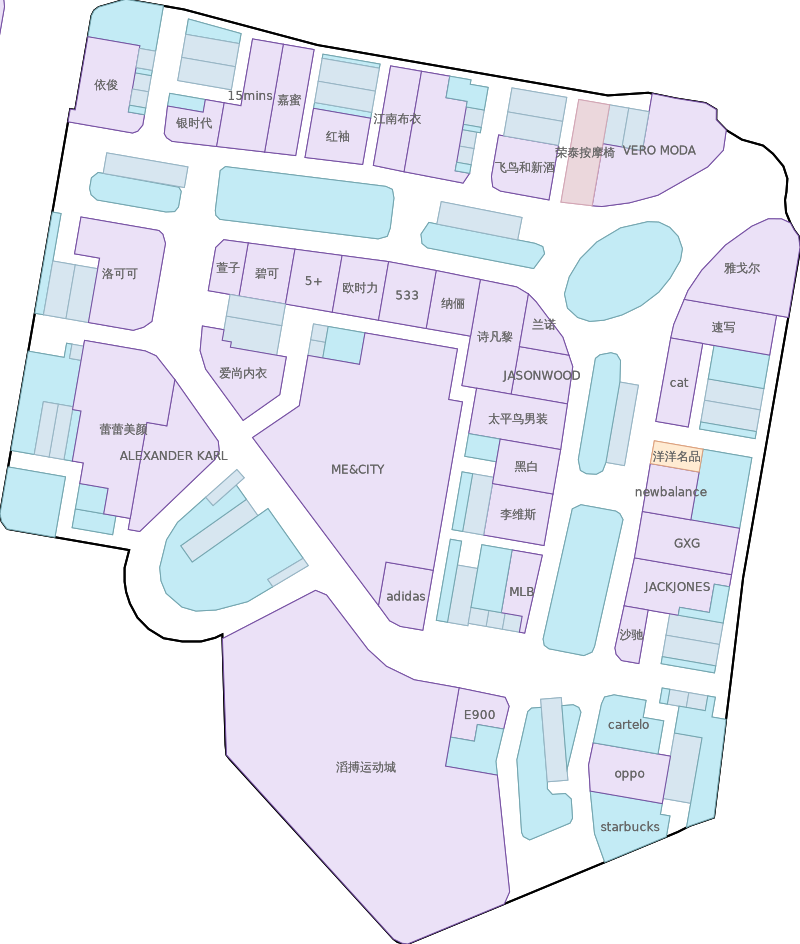

In [8]:
def visualize_trajectory(trajectory, floor_plan_filename, width_meter, height_meter, title=None, mode='lines + markers + text', show=False):
    """
    Copied from from https://github.com/location-competition/indoor-location-competition-20/blob/master/visualize_f.py

    """
    fig = go.Figure()

    # add trajectory
    size_list = [6] * trajectory.shape[0]
    size_list[0] = 10
    size_list[-1] = 10

    color_list = ['rgba(4, 174, 4, 0.5)'] * trajectory.shape[0]
    color_list[0] = 'rgba(12, 5, 235, 1)'
    color_list[-1] = 'rgba(235, 5, 5, 1)'

    position_count = {}
    text_list = []
    for i in range(trajectory.shape[0]):
        if str(trajectory[i]) in position_count:
            position_count[str(trajectory[i])] += 1
        else:
            position_count[str(trajectory[i])] = 0
        text_list.append('        ' * position_count[str(trajectory[i])] + f'{i}')
    text_list[0] = 'Start 0'
    text_list[-1] = f'End {trajectory.shape[0] - 1}'

    fig.add_trace(
        go.Scattergl(
            x=trajectory[:, 0],
            y=trajectory[:, 1],
            mode=mode,
            marker=dict(size=size_list, color=color_list),
            line=dict(shape='linear', color='lightgrey', width=3, dash='dash'),
            text=text_list,
            textposition="top center",
            name='trajectory',
        ))

    # add floor plan
    floor_plan = Image.open(floor_plan_filename)
    fig.update_layout(images=[
        go.layout.Image(
            source=floor_plan,
            xref="x",
            yref="y",
            x=0,
            y=height_meter,
            sizex=width_meter,
            sizey=height_meter,
            sizing="contain",
            opacity=1,
            layer="below",
        )
    ])

    # configure
    fig.update_xaxes(autorange=False, range=[0, width_meter])
    fig.update_yaxes(autorange=False, range=[0, height_meter], scaleanchor="x", scaleratio=1)
    fig.update_layout(
        title=go.layout.Title(
            text=title or "No title.",
            xref="paper",
            x=0,
        ),
        autosize=True,
        width=800,
        height=  800 * height_meter / width_meter,
        template="plotly_white",
    )

    if show:
        fig.show()

    return fig

def visualize_train_trajectory(path):
    """
    Edited from 
    https://www.kaggle.com/ihelon/indoor-location-exploratory-data-analysis
    """
    _id, floor = path.split("/")[:2]
    
    train_floor_data = read_data_file(f"../input/indoor-location-navigation/train/{path}")
    with open(f"../input/indoor-location-navigation/metadata/{_id}/{floor}/floor_info.json") as f:
        train_floor_info = json.load(f)

    return visualize_trajectory(
        train_floor_data.waypoint[:, 1:3], 
        f"../input/indoor-location-navigation/metadata/{_id}/{floor}/floor_image.png",
        train_floor_info["map_info"]["width"], 
        train_floor_info["map_info"]["height"],
        f"Visualization of {path}"
    )

visualize_train_trajectory("5a0546857ecc773753327266/F2/5dccf516c04f060006e6e3c9.txt")

# Inertial Measurement Unit (IMU)
The inertial measurement unit (IMU) is a sensor that measures the force, angular rate and orientation of a body. In this case, the body is a phone. These values are measured by accelerometers, gyroscopes, and in this case also magnetometers. 
* **Accelerometer**: Measures change in velocity ($m/s^2$) 
* **Gyroscopes**: Measures change in rotation ($rad/s$)
* **Magnetometer**: Measures magnetic field ($\mu T$)

The IMU sensor data has the same shape in this case. Note, that this is true for a lot of traces but not all of them. We can concatenate them to a dataframe for the initial analysis of the data.

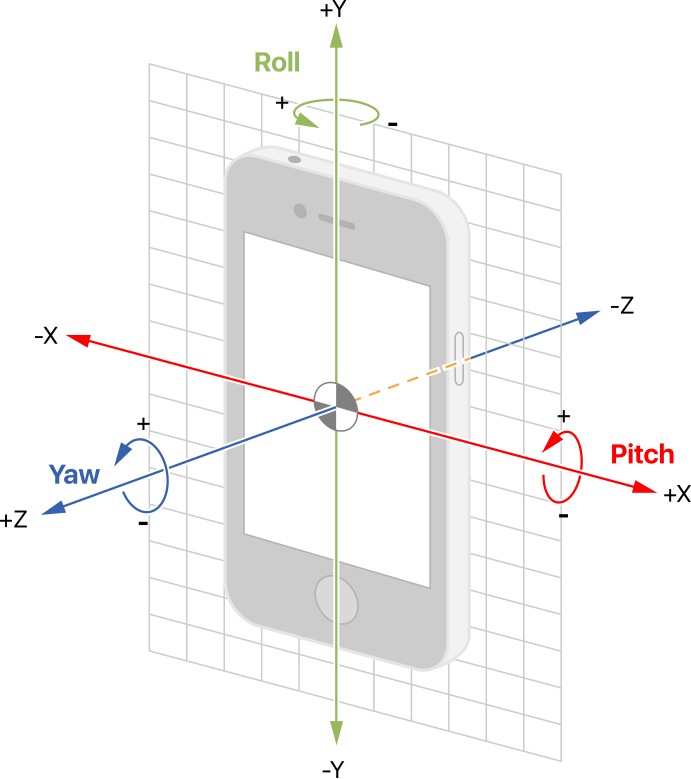
Image Source: https://developer.apple.com/documentation/coremotion/getting_processed_device-motion_data/understanding_reference_frames_and_device_attitude



In [9]:
temp = np.concatenate([sample_file.acce, 
                       sample_file.acce_uncali[:, 1:],
                       sample_file.gyro[:, 1:],
                       sample_file.gyro_uncali[:, 1:],
                       sample_file.magn[:, 1:],
                       sample_file.magn_uncali[:, 1:],
                       sample_file.ahrs[:, 1:],
                      ], axis=1)

imu_df = pd.DataFrame(temp)

imu_df.columns = ['timestamp', 'acce_x','acce_y', 'acce_z','acce_uncali_x','acce_uncali_y', 'acce_uncali_z',
              'gyro_x','gyro_y', 'gyro_z','gyro_uncali_x','gyro_uncali_y', 'gyro_uncali_z',
              'magn_x','magn_y', 'magn_z','magn_uncali_x','magn_uncali_y', 'magn_uncali_z',
              'ahrs_x','ahrs_y', 'ahrs_z']

display(imu_df.head(8).style.set_caption('IMU Data'))

,timestamp,acce_x,acce_y,acce_z,acce_uncali_x,acce_uncali_y,acce_uncali_z,gyro_x,gyro_y,gyro_z,gyro_uncali_x,gyro_uncali_y,gyro_uncali_z,magn_x,magn_y,magn_z,magn_uncali_x,magn_uncali_y,magn_uncali_z,ahrs_x,ahrs_y,ahrs_z
0,1573713056962.000000,-0.407898,3.208404,9.379547,-0.407898,3.208404,9.379547,0.119675,0.118134,-0.168701,0.122360,0.115723,-0.169098,22.111511,-32.519530,-29.766846,-94.444275,-46.537780,-395.381160,0.066476,0.143247,0.901911
1,1573713056982.000000,-0.134949,3.192245,9.204773,-0.134949,3.192245,9.204773,0.134048,-0.119949,-0.176682,0.136734,-0.122360,-0.177078,20.059204,-30.465698,-29.766846,-96.496580,-44.483948,-395.381160,0.063096,0.149306,0.900853
2,1573713057002.000000,-0.079895,2.986938,9.897888,-0.079895,2.986938,9.897888,-0.070496,-0.230743,-0.208649,-0.067810,-0.233154,-0.209045,22.111511,-31.150818,-29.766846,-94.444275,-45.169067,-395.381160,0.062267,0.144842,0.901455
3,1573713057022.000000,0.004501,2.744522,10.971100,0.004501,2.744522,10.971100,-0.318161,-0.182800,-0.220367,-0.315475,-0.185211,-0.220764,22.796630,-31.834412,-29.101562,-93.759155,-45.852660,-394.715880,0.062267,0.144842,0.901455
4,1573713057042.000000,0.119431,2.832504,11.469681,0.119431,2.832504,11.469681,-0.371948,-0.067230,-0.174026,-0.369263,-0.069641,-0.174423,22.111511,-31.150818,-28.436280,-94.444275,-45.169067,-394.050600,0.059240,0.136679,0.903603
5,1573713057061.000000,-0.017044,3.152725,10.999832,-0.017044,3.152725,10.999832,-0.216431,0.089920,-0.110107,-0.213745,0.087509,-0.110504,22.111511,-29.782104,-29.101562,-94.444275,-43.800354,-394.715880,0.056885,0.130476,0.905036
6,1573713057081.000000,-0.269028,3.164703,10.030182,-0.017044,3.152725,10.999832,0.011551,0.331726,-0.024887,0.014236,0.329315,-0.025284,22.796630,-31.150818,-29.766846,-93.759155,-45.169067,-395.381160,0.054625,0.130121,0.905101
7,1573713057101.000000,-0.485702,2.883987,9.680023,-0.485702,2.883987,9.680023,0.077057,0.352493,0.011871,0.079742,0.350082,0.011475,24.165344,-31.150818,-29.101562,-92.390440,-45.169067,-394.715880,0.047848,0.135453,0.905356


Let's have a look at the acceleration first.

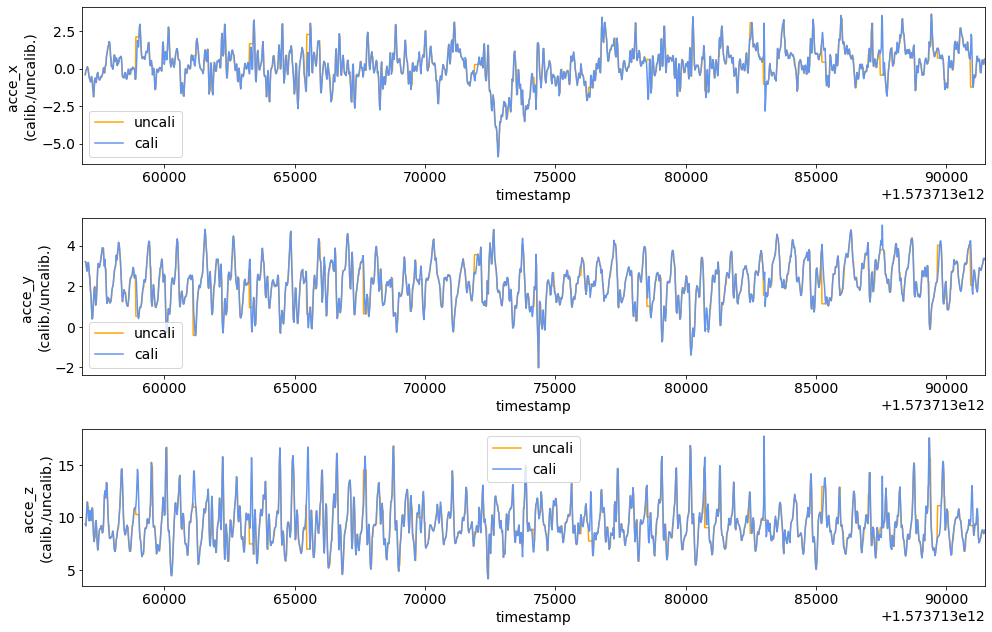

In [10]:
def plot_imu_signals(col, uncali = True):
    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(14, 9))
    ax[0].set_ylabel(f"{col}_x")
    ax[1].set_ylabel(f"{col}_y")
    ax[2].set_ylabel(f"{col}_z")
    if uncali:
        sns.lineplot(x=imu_df.timestamp, y=imu_df[f"{col}_uncali_x"], ax=ax[0], label = 'uncali', color='orange')
        sns.lineplot(x=imu_df.timestamp, y=imu_df[f"{col}_uncali_y"], ax=ax[1], label = 'uncali', color='orange')
        sns.lineplot(x=imu_df.timestamp, y=imu_df[f"{col}_uncali_z"], ax=ax[2], label = 'uncali', color='orange')
        ax[0].set_ylabel(f"{col}_x \n(calib./uncalib.)")
        ax[1].set_ylabel(f"{col}_y \n(calib./uncalib.)")
        ax[2].set_ylabel(f"{col}_z \n(calib./uncalib.)")
    
    sns.lineplot(x=imu_df.timestamp, y=imu_df[f"{col}_x"], ax=ax[0], label='cali', color='cornflowerblue')
    sns.lineplot(x=imu_df.timestamp, y=imu_df[f"{col}_y"], ax=ax[1], label='cali', color='cornflowerblue')
    sns.lineplot(x=imu_df.timestamp, y=imu_df[f"{col}_z"], ax=ax[2], label='cali', color='cornflowerblue')

    for i in range(3):
        ax[i].set_xlim([start_time, end_time])
    plt.tight_layout()
    plt.show()
    
plot_imu_signals('acce')
    


The first thing, we can notice is that the mean value of acce_z looks familiarly close to the standard gravity $g=9.80665 m/s^2$. In contrast to the above picture, the phone is not help upright during the trace but instead it is
> [...] is held flat in front of the surveyors body [...]. 

That is why the value of the z-axis corresponds to $g$.

In [11]:
imu_df.acce_z.mean()

9.441746006999404

In [12]:
# > Therefore, to measure the real acceleration of the device, the contribution of the force of gravity must be removed from the accelerometer data. 
# This can be achieved by applying a high-pass filter. Conversely, a low-pass filter can be used to isolate the force of gravity. 
# The following example shows how you can do this -[Android Developer Docs: Motion Sensors](https://developer.android.com/guide/topics/sensors/sensors_motion#java)

# In this example, alpha is calculated as t / (t + dT),
# where t is the low-pass filter's time-constant and
# dT is the event delivery rate.

"""alpha = 0.8

imu_df['g_x'] = 0
imu_df['g_y'] = 0
imu_df['g_z'] = 9.81

# Isolate the force of gravity with the low-pass filter.
imu_df['g_x'] = alpha * imu_df['g_x'] + (1 - alpha) * imu_df['acce_x'];
imu_df['g_y'] = alpha * imu_df['g_y'] + (1 - alpha) * imu_df['acce_y'];
imu_df['g_z'] = alpha * imu_df['g_z']  + (1 - alpha) * imu_df['acce_z'];

# Remove the gravity contribution with the high-pass filter.
imu_df['lin_acce_x'] = imu_df['acce_x'] - imu_df['g_x'];
imu_df['lin_acce_y'] = imu_df['acce_y'] - imu_df['g_y'];
imu_df['lin_acce_z'] = imu_df['acce_z'] - imu_df['g_z'];

#imu_df['lin_acce_y'].iloc[0]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 3))

sns.lineplot(x=imu_df.timestamp, y=imu_df["acce_x"], label = 'orgi')
sns.lineplot(x=imu_df.timestamp, y=imu_df["lin_acce_x"], label='lin')
sns.lineplot(x=imu_df.timestamp, y=imu_df["g_x"], label='grav')
plt.show()"""

'alpha = 0.8\n\nimu_df[\'g_x\'] = 0\nimu_df[\'g_y\'] = 0\nimu_df[\'g_z\'] = 9.81\n\n# Isolate the force of gravity with the low-pass filter.\nimu_df[\'g_x\'] = alpha * imu_df[\'g_x\'] + (1 - alpha) * imu_df[\'acce_x\'];\nimu_df[\'g_y\'] = alpha * imu_df[\'g_y\'] + (1 - alpha) * imu_df[\'acce_y\'];\nimu_df[\'g_z\'] = alpha * imu_df[\'g_z\']  + (1 - alpha) * imu_df[\'acce_z\'];\n\n# Remove the gravity contribution with the high-pass filter.\nimu_df[\'lin_acce_x\'] = imu_df[\'acce_x\'] - imu_df[\'g_x\'];\nimu_df[\'lin_acce_y\'] = imu_df[\'acce_y\'] - imu_df[\'g_y\'];\nimu_df[\'lin_acce_z\'] = imu_df[\'acce_z\'] - imu_df[\'g_z\'];\n\n#imu_df[\'lin_acce_y\'].iloc[0]\nfig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 3))\n\nsns.lineplot(x=imu_df.timestamp, y=imu_df["acce_x"], label = \'orgi\')\nsns.lineplot(x=imu_df.timestamp, y=imu_df["lin_acce_x"], label=\'lin\')\nsns.lineplot(x=imu_df.timestamp, y=imu_df["g_x"], label=\'grav\')\nplt.show()'

Now let's try to make sense of the x and y components of the acceleration. For this we will calculate the velocity and position from the acceleration and then cross check it with the actual position. To avoid mistakes, we will first play with a little high school level example :)

,timestamp,timestamp_ms,timedelta_s,position,velocity,acceleration
0,1573713056850,2019-11-14 06:30:56.850000,0.000000,-6.000000,0.000000,0.000000
1,1573713057850,2019-11-14 06:30:57.850000,1.000000,-6.000000,0.000000,0.000000
2,1573713058850,2019-11-14 06:30:58.850000,1.000000,-4.800000,1.200000,1.200000
3,1573713059850,2019-11-14 06:30:59.850000,1.000000,-2.400000,2.400000,1.200000
4,1573713060850,2019-11-14 06:31:00.850000,1.000000,1.200000,3.600000,1.200000
5,1573713061850,2019-11-14 06:31:01.850000,1.000000,4.800000,3.600000,0.000000
6,1573713062850,2019-11-14 06:31:02.850000,1.000000,8.400000,3.600000,0.000000
7,1573713063850,2019-11-14 06:31:03.850000,1.000000,12.000000,3.600000,0.000000
8,1573713064850,2019-11-14 06:31:04.850000,1.000000,14.400000,2.400000,-1.200000
9,1573713065850,2019-11-14 06:31:05.850000,1.000000,15.600000,1.200000,-1.200000


,timestamp,timestamp_ms,timedelta_s,position,velocity,acceleration
0,1573713056850,2019-11-14 06:30:56.850000,0.000000,-6.000000,0.000000,0.000000
1,1573713057850,2019-11-14 06:30:57.850000,1.000000,-6.000000,0.000000,0.000000
2,1573713058850,2019-11-14 06:30:58.850000,1.000000,-4.800000,1.200000,1.200000
3,1573713059850,2019-11-14 06:30:59.850000,1.000000,-2.400000,2.400000,1.200000
4,1573713060850,2019-11-14 06:31:00.850000,1.000000,1.200000,3.600000,1.200000
5,1573713061850,2019-11-14 06:31:01.850000,1.000000,4.800000,3.600000,0.000000
6,1573713062850,2019-11-14 06:31:02.850000,1.000000,8.400000,3.600000,0.000000
7,1573713063850,2019-11-14 06:31:03.850000,1.000000,12.000000,3.600000,0.000000
8,1573713064850,2019-11-14 06:31:04.850000,1.000000,14.400000,2.400000,-1.200000
9,1573713065850,2019-11-14 06:31:05.850000,1.000000,15.600000,1.200000,-1.200000


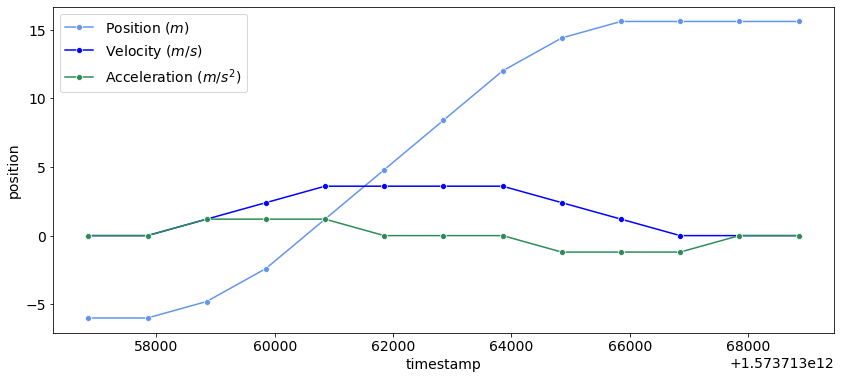

In [13]:
def calc_from_pos(timestamp, pos):
    df = pd.DataFrame({'timestamp' : timestamp, 'position' : pos})
    df['timestamp_ms'] = df['timestamp'].apply(lambda x: datetime.fromtimestamp(x/1000.0))
    df['timedelta_ms'] = df['timestamp_ms'].diff()
    df['timedelta_s'] = df['timedelta_ms'].apply(lambda x: x.total_seconds()).fillna(0)
    df['velocity'] = (df['position'].diff() / df['timedelta_s']).fillna(0)
    df['acceleration'] = (df['velocity'].diff() / df['timedelta_s']).fillna(0)

    return df[['timestamp', 'timestamp_ms', 'timedelta_s', 'position', 'velocity', 'acceleration']]

def calc_from_acce(timestamp, acce, p_0):
    df = pd.DataFrame({'timestamp' : timestamp, 'acceleration' : acce})
    df['timestamp_ms'] = df['timestamp'].apply(lambda x: datetime.fromtimestamp(x/1000.0))
    df['timedelta_ms'] = df['timestamp_ms'].diff()
    df['timedelta_s'] = df['timedelta_ms'].apply(lambda x: x.total_seconds()).fillna(0)
    df['velocity'] = (df['acceleration']*df['timedelta_s']).cumsum()
    df['position'] = p_0 + (df['velocity']*df['timedelta_s']).cumsum()

    return df[['timestamp', 'timestamp_ms', 'timedelta_s', 'position', 'velocity', 'acceleration']]

a_df = calc_from_acce(pd.Series([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]) * 1000 + start_time, 
               pd.Series([0, 0, 1.2, 1.2, 1.2, 0, 0, 0, -1.2, -1.2, -1.2, 0, 0]), -6)
display(a_df.style.set_caption('Calculated Position and Velocity from Acceleration'))

b_df = calc_from_pos(a_df.timestamp, a_df.position)
display(b_df.style.set_caption('Calculated Acceleration and Velocity from Position'))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))
sns.lineplot(x=a_df.timestamp, y=a_df.position, ax=ax, color='cornflowerblue', marker='o', label='Position ($m$)')
sns.lineplot(x=a_df.timestamp, y=a_df.velocity, ax=ax, color='blue', marker='o', label='Velocity ($m/s$)')
sns.lineplot(x=a_df.timestamp, y=a_df.acceleration, ax=ax, color='seagreen', marker='o', label='Acceleration ($m/s^2$)')

plt.show()

Let's apply this to the sample data (Unhide output to see dataframe -->).

Although, we were able to see from the example above that the functions seem to be correct, the `waypoint` data and the `acce` data don't match. This could be caused by the signal's noise. By integrating over the acceleration, we will also integrate the error for each sample, which can quickly accumulate and cause large deviations, as we can see.


,timestamp,timestamp_ms,timedelta_s,position,velocity,acceleration
0,1573713056962.000000,2019-11-14 06:30:56.962000,0.000000,46.302425,0.000000,0.407898
1,1573713056982.000000,2019-11-14 06:30:56.982000,0.020000,46.302479,0.002699,0.134949
2,1573713057002.000000,2019-11-14 06:30:57.002000,0.020000,46.302565,0.004297,0.079895
3,1573713057022.000000,2019-11-14 06:30:57.022000,0.020000,46.302649,0.004207,-0.004501
4,1573713057042.000000,2019-11-14 06:30:57.042000,0.020000,46.302685,0.001818,-0.119431


,timestamp,timestamp_ms,timedelta_s,position,velocity,acceleration
0,1573713056859.000000,2019-11-14 06:30:56.859000,0.000000,46.302425,0.000000,0.000000
1,1573713071518.000000,2019-11-14 06:31:11.518000,14.659000,34.116898,-0.831266,-0.056707
2,1573713075930.000000,2019-11-14 06:31:15.930000,4.412000,30.155294,-0.897916,-0.015106
3,1573713082472.000000,2019-11-14 06:31:22.472000,6.542000,25.324383,-0.738446,0.024376
4,1573713086997.000000,2019-11-14 06:31:26.997000,4.525000,23.943798,-0.305102,0.095767
5,1573713090934.000000,2019-11-14 06:31:30.934000,3.937000,19.683638,-1.082083,-0.197354


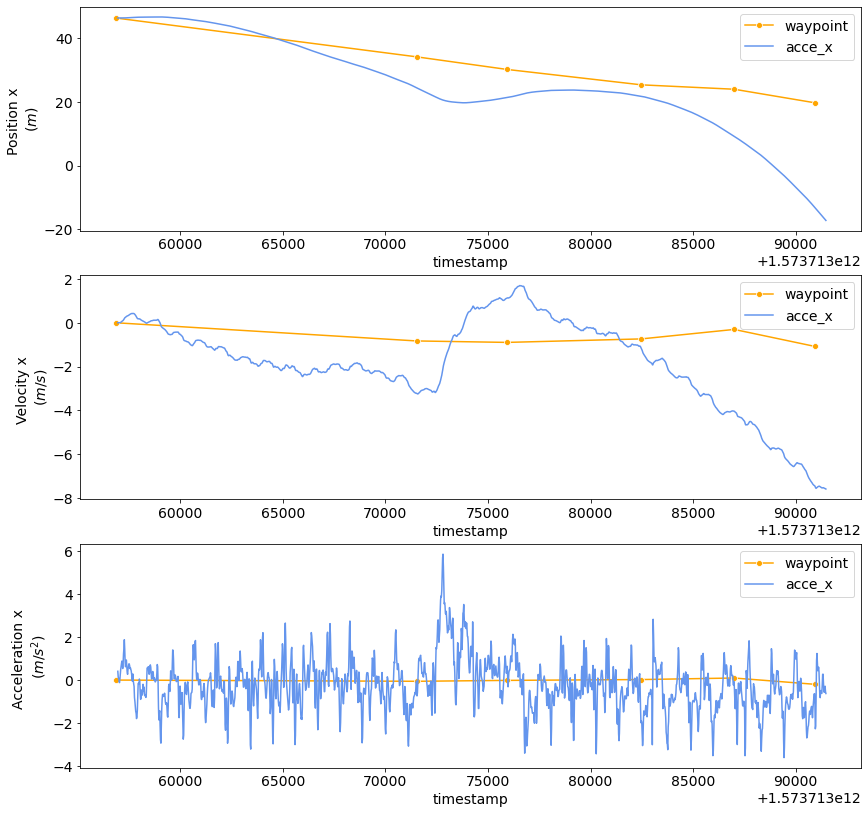

In [14]:
imu_df_temp = calc_from_acce(imu_df.timestamp, 
                      (-1)*imu_df.acce_x, 
                      waypoint_df.waypoint_x.iloc[0])

display(imu_df_temp.head(5).style.set_caption('Calculated Position and Velocity from acce_x'))

waypoint_df_temp = calc_from_pos(waypoint_df.timestamp, waypoint_df.waypoint_x)
display(waypoint_df_temp.style.set_caption('Calculated Acceleration and Velocity from waypoint_x'))


fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(14, 14))

sns.lineplot(x=waypoint_df_temp.timestamp, y=waypoint_df_temp.position, ax=ax[0], color='orange', marker='o', label='waypoint')
sns.lineplot(x=imu_df_temp.timestamp, y=imu_df_temp.position, ax=ax[0], color='cornflowerblue', label='acce_x')
ax[0].set_ylabel('Position x \n($m$)')

sns.lineplot(x=waypoint_df_temp.timestamp, y=waypoint_df_temp.velocity, ax=ax[1], color='orange', marker='o', label='waypoint')
sns.lineplot(x=imu_df_temp.timestamp, y=imu_df_temp.velocity, ax=ax[1], color='cornflowerblue', label='acce_x')
ax[1].set_ylabel('Velocity x \n($m/s$)')

sns.lineplot(x=waypoint_df_temp.timestamp, y=waypoint_df_temp.acceleration, ax=ax[2], color='orange', marker='o', label='waypoint')
sns.lineplot(x=imu_df_temp.timestamp, y=imu_df_temp.acceleration, ax=ax[2], color='cornflowerblue', label='acce_x')
ax[2].set_ylabel('Acceleration x \n($m/s^2$)')

plt.show()

Let's see what happens if we **resample** `acce_x` to 1s samples instead of 0.02s samples. This way, we could smooth out some noise.

Unfortunately, as you can see, the values still seem inplausible. **Analysis is on-going...**

,timestamp,timestamp_ms,timedelta_s,position,velocity,acceleration
0,1573713056972.000000,2019-11-14 06:30:56.972000,0.000000,46.302425,-0.000000,-0.000000
1,1573713057497.117676,2019-11-14 06:30:57.497118,0.525118,46.349225,0.089123,0.169719
2,1573713058497.419922,2019-11-14 06:30:58.497420,1.000302,46.317472,-0.031743,-0.120829
3,1573713059497.705811,2019-11-14 06:30:59.497706,1.000286,45.712533,-0.604766,-0.572858
4,1573713060498.000000,2019-11-14 06:31:00.498000,1.000294,44.826246,-0.886027,-0.281178


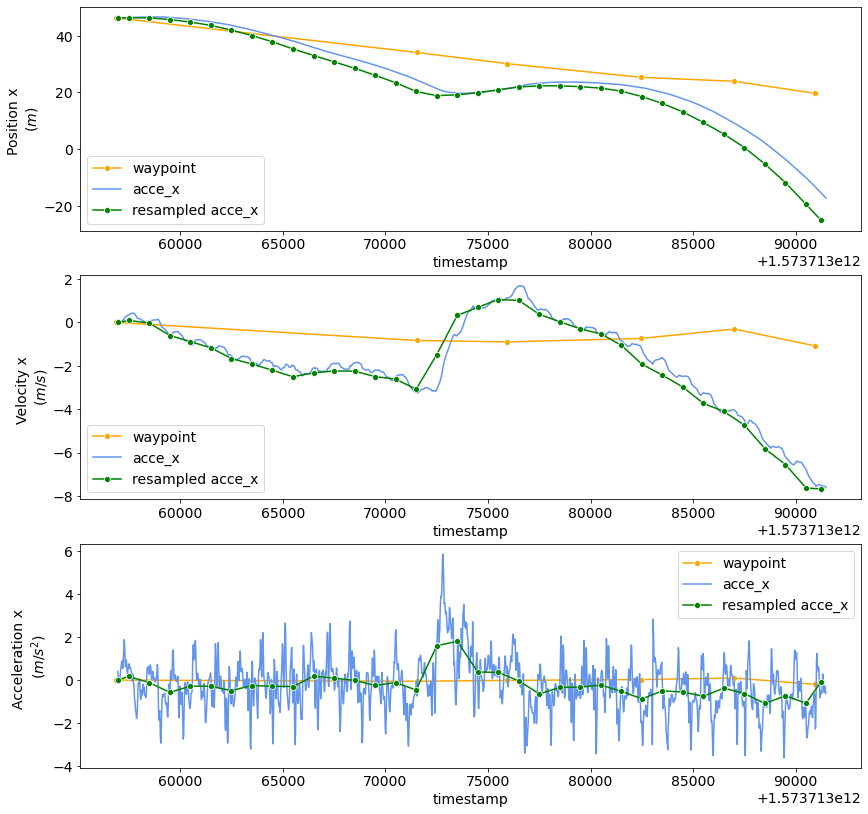

In [15]:
# Resampled
imu_df_resampled = imu_df[['timestamp', 'acce_x' ]].copy()
imu_df_resampled.index = imu_df_resampled['timestamp'].apply(lambda x: datetime.fromtimestamp(x/1000.0))
imu_df_resampled = imu_df_resampled.resample('1S').mean().reset_index(drop=True)
imu_df_resampled.acce_x.iloc[0] = 0
imu_df_resampled.head()

imu_df_temp_resampled = calc_from_acce(imu_df_resampled.timestamp, 
                      (-1)*imu_df_resampled.acce_x , 
                      waypoint_df.waypoint_x.iloc[0])

display(imu_df_temp_resampled.head(5).style.set_caption('Calculated Position and Velocity from resampled acce_x'))

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(14, 14))

sns.lineplot(x=waypoint_df_temp.timestamp, y=waypoint_df_temp.position, ax=ax[0], color='orange', marker='o', label='waypoint')
sns.lineplot(x=imu_df_temp.timestamp, y=imu_df_temp.position, ax=ax[0], color='cornflowerblue', label='acce_x')
sns.lineplot(x=imu_df_temp_resampled.timestamp, y=imu_df_temp_resampled.position, ax=ax[0], color='green', marker='o', label='resampled acce_x')
ax[0].set_ylabel('Position x \n($m$)')

sns.lineplot(x=waypoint_df_temp.timestamp, y=waypoint_df_temp.velocity, ax=ax[1], color='orange', marker='o', label='waypoint')
sns.lineplot(x=imu_df_temp.timestamp, y=imu_df_temp.velocity, ax=ax[1], color='cornflowerblue', label='acce_x')
sns.lineplot(x=imu_df_temp_resampled.timestamp, y=imu_df_temp_resampled.velocity, ax=ax[1], color='green', marker='o', label='resampled acce_x')

ax[1].set_ylabel('Velocity x \n($m/s$)')

sns.lineplot(x=waypoint_df_temp.timestamp, y=waypoint_df_temp.acceleration, ax=ax[2], color='orange', marker='o', label='waypoint')
sns.lineplot(x=imu_df_temp.timestamp, y=imu_df_temp.acceleration, ax=ax[2], color='cornflowerblue', label='acce_x')
sns.lineplot(x=imu_df_temp_resampled.timestamp, y=imu_df_temp_resampled.acceleration, ax=ax[2], color='green', marker='o', label='resampled acce_x')

ax[2].set_ylabel('Acceleration x \n($m/s^2$)')

plt.show()

,timestamp,timestamp_ms,timedelta_s,position,velocity,acceleration
0,1573713056962.000000,2019-11-14 06:30:56.962000,0.000000,56.807760,0.000000,0.000001
1,1573713056982.000000,2019-11-14 06:30:56.982000,0.020000,56.807754,-0.000323,-0.016158
2,1573713057002.000000,2019-11-14 06:30:57.002000,0.020000,56.807658,-0.004752,-0.221465
3,1573713057022.000000,2019-11-14 06:30:57.022000,0.020000,56.807378,-0.014030,-0.463882
4,1573713057042.000000,2019-11-14 06:30:57.042000,0.020000,56.806947,-0.021548,-0.375900


,timestamp,timestamp_ms,timedelta_s,position,velocity,acceleration
0,1573713056859.000000,2019-11-14 06:30:56.859000,0.000000,56.807760,0.000000,0.000000
1,1573713071518.000000,2019-11-14 06:31:11.518000,14.659000,47.213530,-0.654494,-0.044648
2,1573713075930.000000,2019-11-14 06:31:15.930000,4.412000,48.920160,0.386816,0.236018
3,1573713082472.000000,2019-11-14 06:31:22.472000,6.542000,47.503628,-0.216529,-0.092226
4,1573713086997.000000,2019-11-14 06:31:26.997000,4.525000,51.767067,0.942196,0.256072
5,1573713090934.000000,2019-11-14 06:31:30.934000,3.937000,54.200680,0.618139,-0.082311


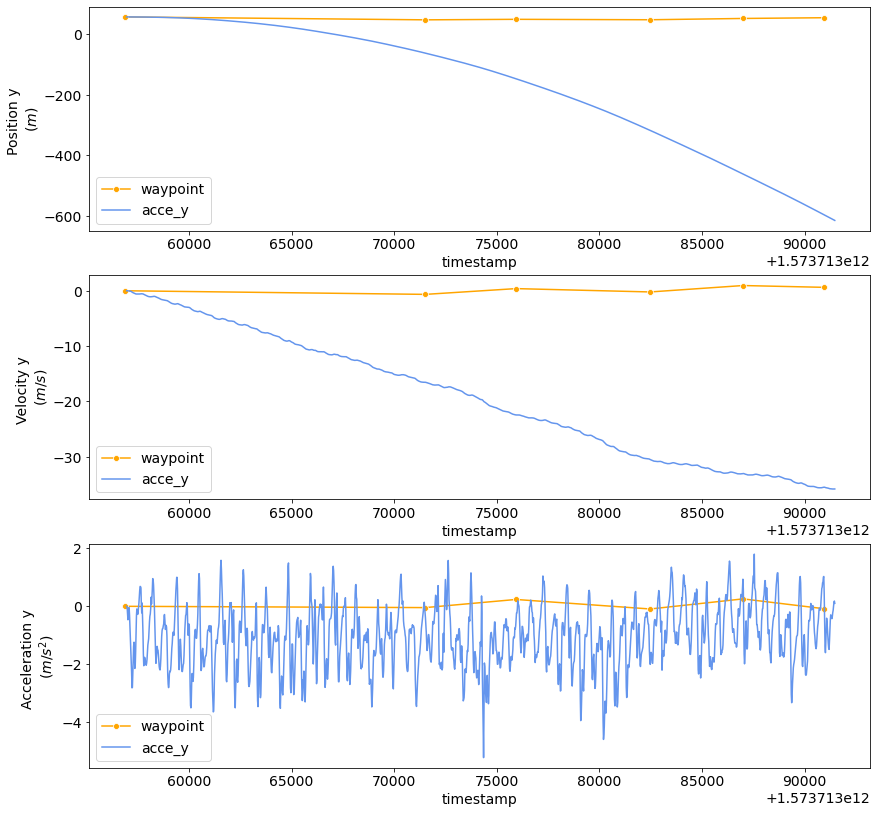

In [16]:
imu_df_temp = calc_from_acce(imu_df.timestamp, 
                      imu_df.acce_y - 3.208404, 
                      waypoint_df.waypoint_y.iloc[0])

display(imu_df_temp.head(5).style.set_caption('Calculated Position and Velocity from acce_y'))

waypoint_df_temp = calc_from_pos(waypoint_df.timestamp, waypoint_df.waypoint_y)
display(waypoint_df_temp.style.set_caption('Calculated Acceleration and Velocity from waypoint_y'))


fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(14, 14))

sns.lineplot(x=waypoint_df_temp.timestamp, y=waypoint_df_temp.position, ax=ax[0], color='orange', marker='o', label='waypoint')
sns.lineplot(x=imu_df_temp.timestamp, y=imu_df_temp.position, ax=ax[0], color='cornflowerblue', label='acce_y')
ax[0].set_ylabel('Position y \n($m$)')

sns.lineplot(x=waypoint_df_temp.timestamp, y=waypoint_df_temp.velocity, ax=ax[1], color='orange', marker='o', label='waypoint')
sns.lineplot(x=imu_df_temp.timestamp, y=imu_df_temp.velocity, ax=ax[1], color='cornflowerblue', label='acce_y')
ax[1].set_ylabel('Velocity y \n($m/s$)')

sns.lineplot(x=waypoint_df_temp.timestamp, y=waypoint_df_temp.acceleration, ax=ax[2], color='orange', marker='o', label='waypoint')
sns.lineplot(x=imu_df_temp.timestamp, y=imu_df_temp.acceleration, ax=ax[2], color='cornflowerblue', label='acce_y')
ax[2].set_ylabel('Acceleration y \n($m/s^2$)')

plt.show()

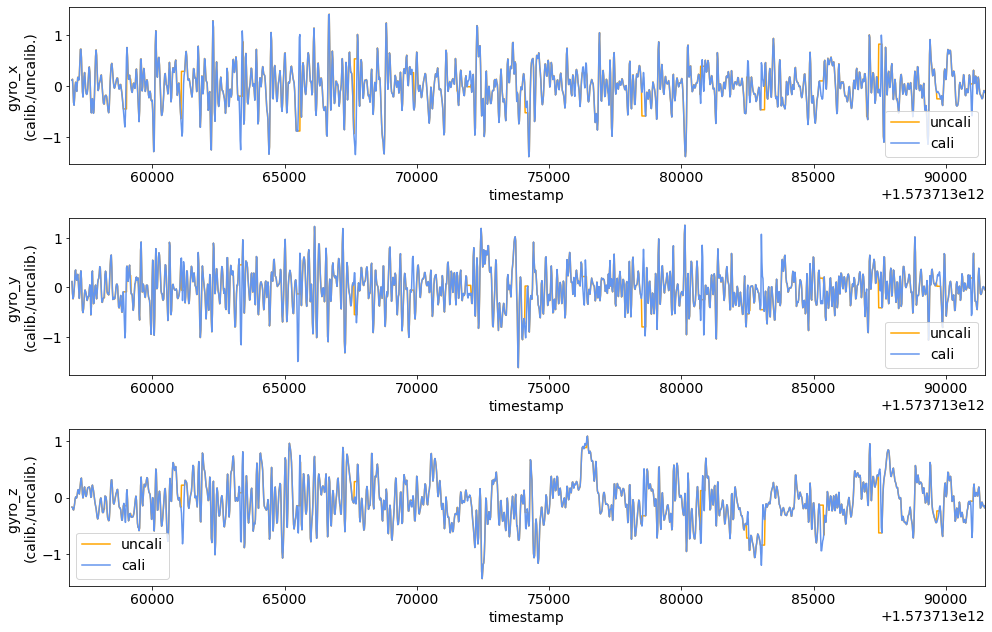

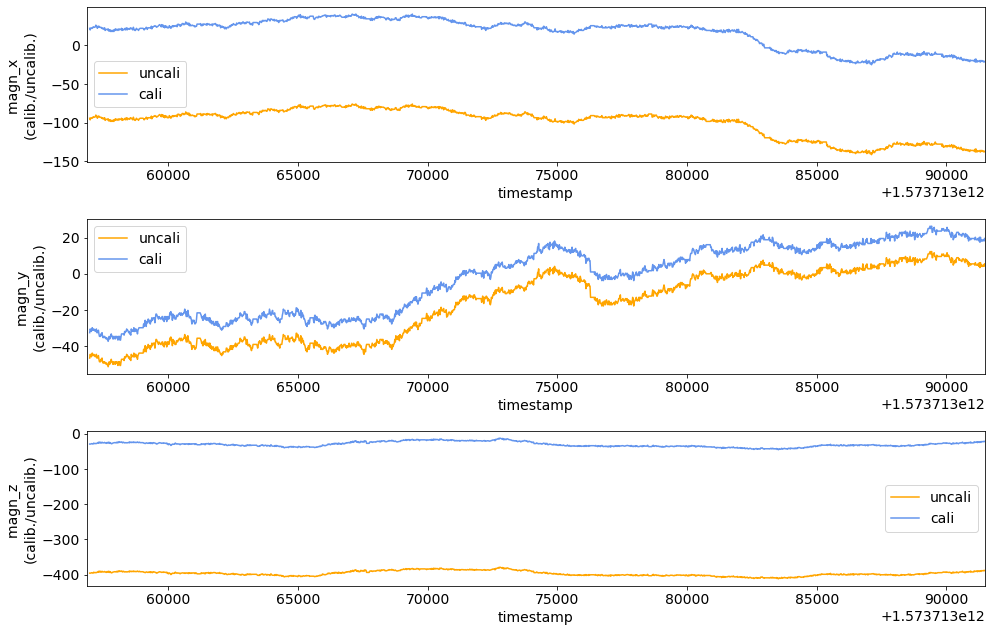

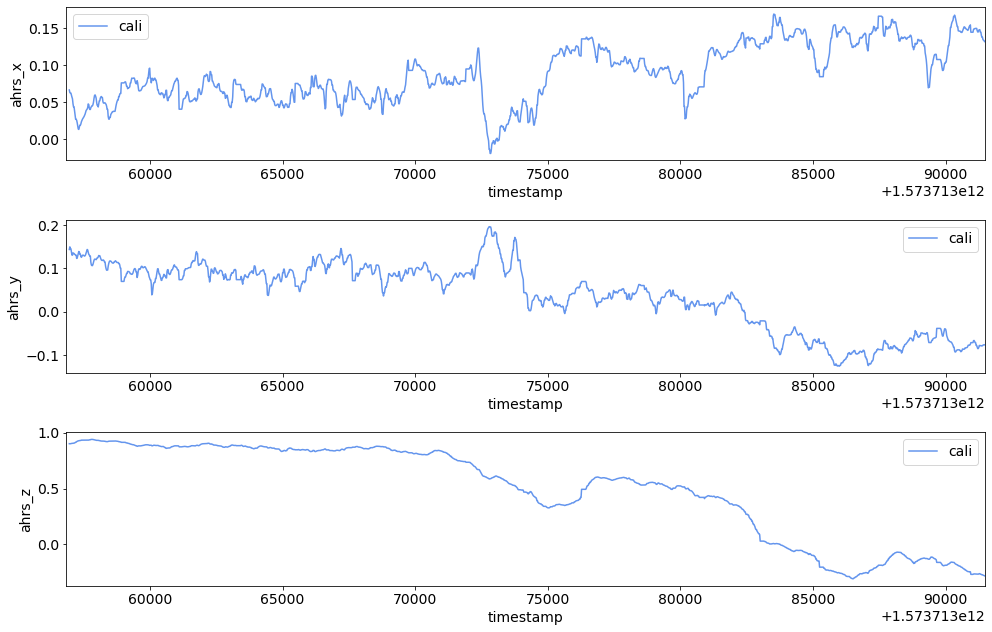

In [17]:
plot_imu_signals('gyro')
plot_imu_signals('magn')

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(14, 9))
col = 'ahrs'
sns.lineplot(x=imu_df.timestamp, y=imu_df[f"{col}_x"], ax=ax[0], label='cali', color='cornflowerblue')
sns.lineplot(x=imu_df.timestamp, y=imu_df[f"{col}_y"], ax=ax[1], label='cali', color='cornflowerblue')
sns.lineplot(x=imu_df.timestamp, y=imu_df[f"{col}_z"], ax=ax[2], label='cali', color='cornflowerblue')
for i in range(3):
    ax[i].set_xlim([start_time, end_time])

plt.tight_layout()
plt.show()

# WiFi
* Service set ID (SSID): name identifier for wireless networks (can be changed)
* Basic Service Set ID (BSSID): MAC address of the access point (cannot be changed)
* Received signal strength indication (RSSI)


In [18]:
wifi_df = pd.DataFrame(sample_file.wifi)
wifi_df.columns = ['timestamp', 'ssid', 'bssid', 'rssi', 'last_seen_timestamp']
wifi_df = wifi_df.pivot(index='timestamp', columns=['ssid', 'bssid'])['rssi']
wifi_df.reset_index(drop=False, inplace=True)
wifi_df.style.set_caption('WiFi')

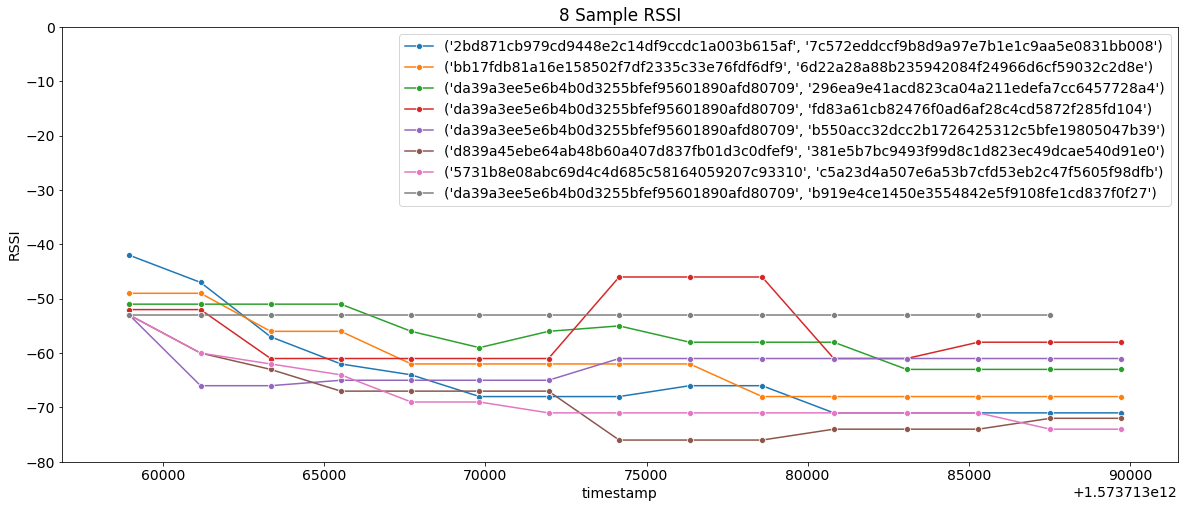

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 8))

for i, c in enumerate(wifi_df.columns):
    if c != ('timestamp', ''):
        sns.lineplot(x=wifi_df.timestamp.astype(int), y=wifi_df[c].replace('NaN', np.nan).astype(float), ax=ax, marker='o', label=c)
    if i == 8:
        break
ax.set_xlim([start_time, end_time])
ax.set_ylim([-80, 0])

ax.set_ylabel('RSSI')
ax.set_title('8 Sample RSSI')
plt.show()

# iBeacon
There iBeacon data is analyzed separately in [this notebook](https://bit.ly/3CbNx3H).

# iBeacon Understanding and Feature Engineering
The aim of this notebook is to get a better understanding of the iBeacon technology. According to Wikipedia "iBeacon is a protocol developed by Apple [...] in 2013. Various vendors have since made iBeacon-compatible hardware transmitters – typically called beacons – a class of Bluetooth Low Energy (BLE) devices that broadcast their identifier to nearby portable electronic devices."

In regards to using the iBeacon technology for precise indoor localization, the Apple developers' guide states: "Due to the issues around signal strength and the variabilities in deployment environments, iBeacon technology is not intended to be used for specific location identification. It should be capable of providing room-level accuracy, but there are many factors that need to be considered to build a successful deployment."

The fact that iBeacon technology is not precise at meter-level is also reflected in this discussion topic "How much value is TYPE_BEACON adding?". Nonetheless, let's explore this topic a little bit.